In [1]:
!pip -q install tensorflow[keras]


[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [2]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras import utils
import tensorflow as tf
import tensorflow.compat.v1 as tf1

import pandas as pd
import numpy as np

2024-12-16 20:23:51.772489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-16 20:23:51.774414: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 20:23:51.777314: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-16 20:23:51.785794: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734380631.800288    3485 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734380631.80

In [201]:
predict_target = "price"

In [202]:
df = pd.read_csv("clean_IKEA_dataset.csv")

In [203]:
scaler = MinMaxScaler()

df[['size', 'width', 'height', 'depth', 'discount_amount','price']] = scaler.fit_transform(df[['size', 'width', 'height', 'depth', 'discount_amount','price']])
df.head()


,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
0,FREKVENS,Bar furniture,0.027343,265.0,True,No,"Bar table, in/outdoor, 51x51 cm",0.179398,0.140200,0.119332,0,1,1,0,0.0,0.000370
1,NORDVIKEN,Bar furniture,0.103527,995.0,False,No,"Bar table, 140x80 cm",0.179398,0.148784,0.188544,0,1,1,0,0.0,0.000616
2,NORDVIKEN / NORDVIKEN,Bar furniture,0.218326,2095.0,False,No,Bar table and 4 bar stools,0.179398,0.138157,0.123976,0,0,0,0,0.0,0.000000
3,STIG,Bar furniture,0.006888,69.0,True,Yes,"Bar stool with backrest, 74 cm",0.191406,0.141631,0.140811,0,1,1,1,0.0,0.022012
4,NORBERG,Bar furniture,0.023168,225.0,True,No,"Wall-mounted drop-leaf table, ...",0.230469,0.060086,0.174224,0,1,1,1,0.0,0.014008


In [204]:
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(df.category)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = utils.to_categorical(encoded_Y)

In [ ]:
with open("scaler.pkl", "wb") as handle:
    pickle.dump(scaler, handle)

df_train.to_parquet("X_train.parquet")
df_test.to_parquet("X_test.parquet")

In [205]:
df_train , df_test, dummy_y_train, dummy_y_test = train_test_split(df, dummy_y, shuffle=True, test_size=0.3)

In [206]:
# List to hold all feature inputs
inputs = {}

# Numeric columns
numeric_keys = ['discount_amount', 'size', 'width', 'height', 'depth', 'width_d', 'height_d', 'depth_d', 'price']
numeric_keys.remove(predict_target)
for key in numeric_keys:
    inputs[key] = tf.keras.Input(shape=(1,), name=key, dtype=tf.float32)

# Categorical column with vocabulary list and transformation
other_colors_input = tf.keras.Input(shape=(1,), name='other_colors', dtype='string')
other_colors_encoded = tf.keras.layers.StringLookup(vocabulary=['Yes', 'No'], output_mode='one_hot')(other_colors_input)

# Category with a longer vocabulary list
category_vocab = ['Bar furniture', 'Beds', 'Bookcases & shelving units',
                  'Cabinets & cupboards', 'Café furniture', 'Chairs',
                  'Chests of drawers & drawer units', "Children's furniture",
                  'Nursery furniture', 'Outdoor furniture', 'Room dividers',
                  'Sideboards, buffets & console tables', 'Sofas & armchairs',
                  'Tables & desks', 'Trolleys', 'TV & media furniture', 'Wardrobes']
category = tf.keras.Input(shape=(1,), name='category', dtype='string')
category_encoded = tf.keras.layers.StringLookup(vocabulary=category_vocab, output_mode='one_hot')(category)

# Correctly add all inputs to a dictionary including the encoded output
inputs['other_colors'] = other_colors_input
inputs['category'] = category

# Concatenate features ensuring all are numeric
# Include the output from the encoding in the concatenation
all_features = tf.keras.layers.concatenate([inputs[key] for key in numeric_keys] + [other_colors_encoded] + [category_encoded])

# Model creation
pre_processing_model = tf.keras.Model(inputs=[inputs[key] for key in inputs], outputs=all_features)

In [207]:
def create_model(my_learning_rate, preprocessing_layer):
    model = tf.keras.Sequential([
        preprocessing_layer,
        tf.keras.layers.Dense(20, activation='relu', name='Hidden1'),
        tf.keras.layers.Dense(10, activation='relu', name='Hidden2'),
        tf.keras.layers.Dense(1, name='Output')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                  loss='mean_squared_error',
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

Epoch 1/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 2s 835us/step - loss: 0.0190 - mean_squared_error: 0.0190
Epoch 2/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 3/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 831us/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 4/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 5/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 6/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - loss: 0.0083 - mean_squared_error: 0.0083
Epoch 7/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 822us/step - loss: 0.0085 - mean_squared_error: 0.0085
Epoch 8/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 826us/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 9/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 842us/step - loss: 0.0078 - mean_squared_error: 0.0078
Epoch 10/20
1289/1289 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - loss: 0.0076 - mean_squared_error: 0.0076

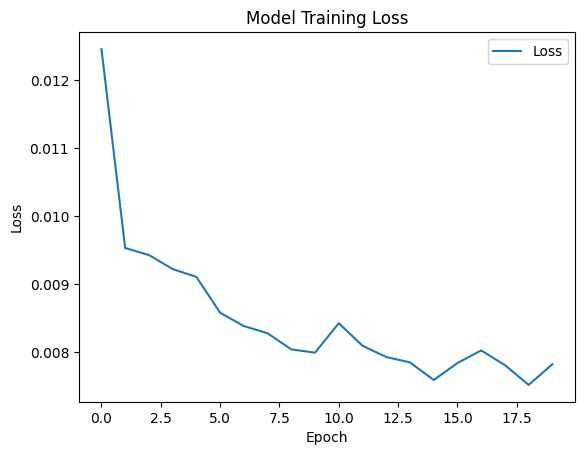

In [208]:
# Setup parameters
learning_rate = 0.01
epochs = 20
batch_size = 2

# Create the model
model = create_model(learning_rate, pre_processing_model)

# Prepare the data
# Exclude non-numeric and unnecessary columns for input
feature_columns = [col for col in df_train.columns if col not in ['name', 'category', 'short_description', 'sellable_online', 'other_colors', predict_target]]
features = df_train[feature_columns].astype('float32')
features["category"] = df_train["category"].astype("string")
features["other_colors"] = df_train["other_colors"].astype("string")
dict_features = {key: features[[key]] for key in features.keys()}

labels = df_train[[predict_target]]  # Target variable
dict_labels = {key: labels[[key]] for key in labels.keys()}

# Fit the model
history = model.fit(dict_features, dict_labels, epochs=epochs, batch_size=batch_size)

# Optionally, plot the loss or any other metric
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Training Loss')
plt.legend()
plt.show()


In [209]:
test_features = {name:np.array(value) for name, value in df_test.items()}
test_label = np.array(test_features.pop(predict_target)) # isolate the label

print("\n Evaluate the new model against the test set:")
model.evaluate(x = test_features, y = test_label, batch_size=batch_size)


 Evaluate the new model against the test set:
553/553 ━━━━━━━━━━━━━━━━━━━━ 1s 838us/step - loss: 0.0094 - mean_squared_error: 0.0094


[0.008280222304165363, 0.008280222304165363]

In [257]:
input_test_df = df_test
input_test = {key: input_test_df[[key]] for key in input_test_df.keys()}
prediction = model(input_test)
prediction

<tf.Tensor: shape=(1106, 1), dtype=float32, numpy=
array([[0.13737938],
       [0.13818496],
       [0.08252695],
       ...,
       [0.1968913 ],
       [0.18533403],
       [0.06058048]], dtype=float32)>

In [258]:
prediction_value = prediction.numpy()
predicted_df = input_test_df.copy()
predicted_df[predict_target] = prediction_value

In [259]:
predicted_df[['size', 'width', 'height', 'depth', 'discount_amount','price']] = scaler.inverse_transform(predicted_df[['size', 'width', 'height', 'depth', 'discount_amount','price']])
predicted_df

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
3674,ELVARLI,Wardrobes,1319.369201,1735.0,True,No,"2 sections, 165x55x216 cm",55.000000,216.000000,164.000000,1,1,1,1,490.0,1948320.0
2917,MÖRBYLÅNGA / BALTSAR,Tables & desks,1327.088331,6065.0,True,No,"Table and 6 chairs, 220x100 cm",52.813953,72.610169,100.000000,0,1,0,0,0.0,100.0
3003,INGATORP / INGOLF,Tables & desks,793.773254,2615.0,True,No,"Table and 6 chairs, 155/215 cm",52.813953,74.000000,87.000000,0,1,1,0,0.0,6438.0
3300,HAVSTA,TV & media furniture,340.866811,995.0,True,Yes,"TV bench with plinth, 160x62x...",47.000000,62.000000,160.000000,0,1,1,1,0.0,466240.0
910,BESTÅ,Cabinets & cupboards,96.322492,25.0,True,No,"Glass shelf, 56x16 cm",16.000000,113.408696,56.000000,0,1,0,1,0.0,896.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208,NYHAMN,Beds,1228.861245,1520.0,True,Yes,Sofa-bed with triple cushion,97.000000,90.000000,200.000000,0,1,1,1,0.0,1746000.0
906,BESTÅ,Cabinets & cupboards,461.833363,965.0,True,Yes,"Storage combination w glass doors, ...",42.000000,193.000000,60.000000,0,1,1,1,0.0,486360.0
1547,EKEDALEN / EKEDALEN,Chairs,1889.612369,1245.0,False,No,"Table and 2 chairs, 80/120 cm",60.676259,76.837931,66.156812,0,0,0,0,0.0,1.0
3638,PAX,Wardrobes,1778.870645,3760.0,True,No,"Wardrobe, 150x66x236 cm",66.000000,236.000000,150.000000,0,1,1,1,0.0,2336400.0


In [260]:
predicted_df[predicted_df["price"]<0]

,name,category,price,old_price,sellable_online,other_colors,short_description,depth,height,width,discounted,width_d,height_d,depth_d,discount_amount,size
962,ENERYDA,Cabinets & cupboards,-154.873511,35.0,True,Yes,"Cup handle, 89 mm",30.000000,113.408696,22.000000,0,1,0,1,0.0,660.0
1034,ORRNÄS,Cabinets & cupboards,-20.626719,17.0,True,No,"Knob, 17 mm",30.000000,113.408696,17.000000,0,1,0,1,0.0,510.0
385,ALGOT,Bookcases & shelving units,-165.160307,10.0,True,No,"Rod for brackets, 60 cm",36.922737,131.097285,60.000000,1,1,0,0,4.0,60.0
3338,FIXA,TV & media furniture,-371.505624,7.0,True,No,Drill template,37.150376,99.664062,64.000000,1,1,0,0,1.4,64.0
511,EKET,Bookcases & shelving units,-279.551134,15.0,True,No,"Foot, adjustable",36.922737,131.097285,8.000000,0,1,0,0,0.0,8.0
956,ÖSTERNÄS,Cabinets & cupboards,-333.099158,49.0,True,No,"Leather handle, 65 mm",37.493671,113.408696,25.000000,0,1,0,0,0.0,25.0
3386,MÖLLARP,TV & media furniture,-291.648132,17.0,True,No,"Handle, 106 mm",28.000000,99.664062,9.000000,0,1,0,1,0.0,252.0
3260,TIMMERVIKEN,TV & media furniture,-10.567448,100.0,True,No,"Door/drawer front, 60x38 cm",37.150376,38.000000,60.000000,0,1,1,0,0.0,2280.0
1986,MASTHOLMEN,Outdoor furniture,-73.758531,255.0,True,No,"Coffee table, outdoor, 68 cm",68.221154,45.000000,88.154762,0,0,1,0,0.0,45.0
3400,BAGGANÄS,TV & media furniture,-346.042573,50.0,True,Yes,"Handle, 335 mm",31.000000,99.664062,9.000000,0,1,0,1,0.0,279.0


In [256]:
original_price = list(predicted_df.to_dict()['old_price'].values())[0]
predicted_new_price = list(predicted_df.to_dict()['price'].values())[0]
predicted_discount = original_price-predicted_new_price

print(f"Original Price: {original_price}\nPredicted Discount: {predicted_discount}\nNew Price: {predicted_new_price}")

Original Price: 2615.0
Predicted Discount: 1821.2267456650734
New Price: 793.7732543349266


In [ ]:
model.save("model.keras")